In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import csv

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sp-500-stocks/sp500_stocks.csv
/kaggle/input/sp-500-stocks/sp500_companies.csv
/kaggle/input/sp-500-stocks/sp500_index.csv


In [2]:
#create df for Tesla Stock price since 2019
sp500 = pd.read_csv('/kaggle/input/sp-500-stocks/sp500_stocks.csv')
stock = sp500[(sp500['Symbol']=='GOOG') & (sp500['Date'].apply(lambda x:int(x.split('-')[0])) >= 2019)]

In [3]:
#Creating np array 
def data_split(arr,split_ratio):
    spt = round(len(arr)*split_ratio)
    arr_train = arr[:spt]
    arr_valid = arr[spt:]
    return arr_train,arr_valid

date = stock['Date'].to_numpy()
close = stock['Close'].apply(lambda x:x/100).to_numpy()[...,None]
split_ratio = 0.7


date_train,date_valid = data_split(date,split_ratio)
close_train,close_valid = data_split(close,split_ratio)



In [4]:
#Creating Tensorflow data set
import tensorflow as tf
from tensorflow import keras 

def window(arr,window_size,batch_size,shuffle):
    dataset = tf.data.Dataset.from_tensor_slices(arr)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder = True)
    dataset = dataset.flat_map(lambda window:window.batch(window_size+1))
    dataset = dataset.map(lambda window:(window[:-1],window[-1]))
    dataset = dataset.shuffle(shuffle)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
window_size = 40
batch_size = 80
shuffle_buffer_size = 10000

train_data = window(close_train,window_size,batch_size,shuffle_buffer_size)


2022-06-30 15:11:06.036472: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=40, kernel_size=40,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size,1]),
    tf.keras.layers.LSTM(40,return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(20,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 40, 40)            1640      
_________________________________________________________________
lstm (LSTM)                  (None, 40, 40)            12960     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                4880      
_________________________________________________________________
dense (Dense)                (None, 20)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 20,121
Trainable params: 20,121
Non-trainable params: 0
____________________________________________________

In [7]:
init_weights = model.get_weights()
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(        epoch + 1, model.optimizer.lr.numpy()))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_data, epochs=100, callbacks=[lr_schedule,PrintLR()])



Epoch 1/100


2022-06-30 15:11:10.834959: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


8/8 [==============================] - 5s 79ms/step - loss: 14.6543

Learning rate for epoch 1 is 9.999999747378752e-06
Epoch 2/100
8/8 [==============================] - 1s 74ms/step - loss: 14.6286

Learning rate for epoch 2 is 1.1220184205740225e-05
Epoch 3/100
8/8 [==============================] - 1s 78ms/step - loss: 14.5756

Learning rate for epoch 3 is 1.2589253856276628e-05
Epoch 4/100
8/8 [==============================] - 1s 74ms/step - loss: 14.5114

Learning rate for epoch 4 is 1.4125375855655875e-05
Epoch 5/100
8/8 [==============================] - 1s 80ms/step - loss: 14.4807

Learning rate for epoch 5 is 1.5848931070649996e-05
Epoch 6/100
8/8 [==============================] - 1s 74ms/step - loss: 14.4596

Learning rate for epoch 6 is 1.778279329300858e-05
Epoch 7/100
8/8 [==============================] - 1s 76ms/step - loss: 14.4347

Learning rate for epoch 7 is 1.995262391574215e-05
Epoch 8/100
8/8 [==============================] - 1s 74ms/step - loss: 14.4087

Lea

(1e-05, 10.0, 1.0, 15.0)

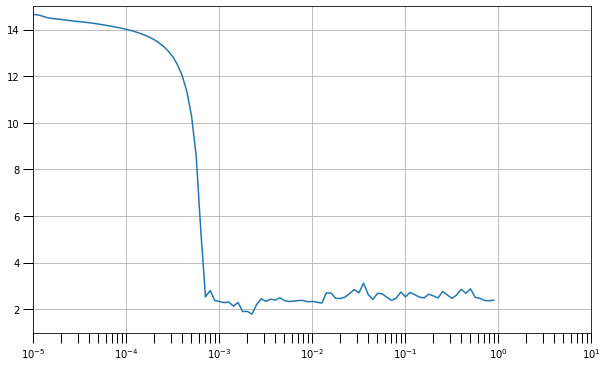

In [8]:
# Define the learning rate array
lrs = 1e-5 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-5, 10, 1, 15])

In [9]:
tf.keras.backend.clear_session()
model.set_weights(init_weights)

In [10]:
learning_rate=0.004
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate,momentum=0.9)
loss=tf.keras.losses.Huber()

model.compile(optimizer=optimizer,loss=loss, metrics=['mae'])


In [11]:
history = model.fit(train_data,epochs=100)

Epoch 1/100
8/8 [==============================] - 5s 79ms/step - loss: 14.2909 - mae: 14.7909
Epoch 2/100
8/8 [==============================] - 1s 78ms/step - loss: 12.7059 - mae: 13.2059
Epoch 3/100
8/8 [==============================] - 1s 79ms/step - loss: 6.2083 - mae: 6.6952
Epoch 4/100
8/8 [==============================] - 1s 83ms/step - loss: 3.2376 - mae: 3.7026
Epoch 5/100
8/8 [==============================] - 1s 81ms/step - loss: 2.3751 - mae: 2.8330
Epoch 6/100
8/8 [==============================] - 1s 90ms/step - loss: 2.4551 - mae: 2.9185
Epoch 7/100
8/8 [==============================] - 1s 97ms/step - loss: 2.3862 - mae: 2.8423
Epoch 8/100
8/8 [==============================] - 1s 82ms/step - loss: 2.2258 - mae: 2.6871
Epoch 9/100
8/8 [==============================] - 1s 82ms/step - loss: 2.0161 - mae: 2.4631
Epoch 10/100
8/8 [==============================] - 1s 102ms/step - loss: 1.9605 - mae: 2.4148
Epoch 11/100
8/8 [==============================] - 1s 89ms/step

In [12]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

NameError: name 'plot_series' is not defined

In [ ]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

In [ ]:
def model_forecast(model,series,window_size,batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda w:w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

forecast_close = close[round(len(close)*split_ratio)-window_size:-1]

forecast = model_forecast(model,forecast_close,window_size,batch_size)

results = forecast.squeeze()

plot_series(date_valid, (close_valid, results))

In [ ]:
print(tf.keras.metrics.mean_absolute_error(close_valid, results).numpy())